In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

In [2]:
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua import Operator, run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import portfolio
from qiskit.aqua.translators.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import VQE, QAOA, ExactEigensolver
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from qiskit.aqua.components.variational_forms import RY
import qiskit.aqua.translators.ising.vehicle_routing as vr
import numpy as np
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import math

In [3]:
#Create a random customer-customer distance matrix
N=5
# Initialize the problem by defining the parameters
n = 5  # number of nodes + depot (n+1)
K = 1  # number of vehicles

np.random.seed(1543)
#Array of X-Coordinates
#xs = (np.random.rand(n) - 0.5) * 10
xs = np.random.rand(n) * 10
#Array of Y-Coordinates
ys = np.random.rand(n) * 10

print (xs,ys)
instance = np.zeros([n, n])
for i in range(0, n):
    for j in range(i + 1, n):
        #print ('nodes = ',(xs[i],ys[i]),(xs[j],ys[j]))
        #Distance squared
        #instance[i, j] = (xs[i] - xs[j]) ** 2 + (ys[i] - ys[j]) ** 2
        instance[i, j] = math.sqrt((xs[i] - xs[j]) ** 2 + (ys[i] - ys[j]) ** 2)
        instance[i, j] = math.ceil(instance[i, j])
        #jith element is made the same as ijth element - so that the matrix is a symmetric
        instance[j, i] = instance[i, j]
        #print (instance[i,j])

print ('distance matrix : \n',instance)

[5.51003914 7.55963937 4.35716491 0.42931423 7.98724481] [2.27415725 6.05534574 5.79231007 4.75107783 5.60258683]
distance matrix : 
 [[0. 5. 4. 6. 5.]
 [5. 0. 4. 8. 1.]
 [4. 4. 0. 5. 4.]
 [6. 8. 5. 0. 8.]
 [5. 1. 4. 8. 0.]]


{0: (5.5100391375334326, 2.2741572523311104), 1: (7.559639370825573, 6.055345738402197), 2: (4.357164910072608, 5.7923100691603135), 3: (0.4293142250893367, 4.751077828674756), 4: (7.9872448071072135, 5.602586826724487)}
{(0, 1): 5, (0, 2): 4, (0, 3): 6, (0, 4): 5, (1, 2): 4, (1, 3): 8, (1, 4): 1, (2, 3): 5, (2, 4): 4, (3, 4): 8}


/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


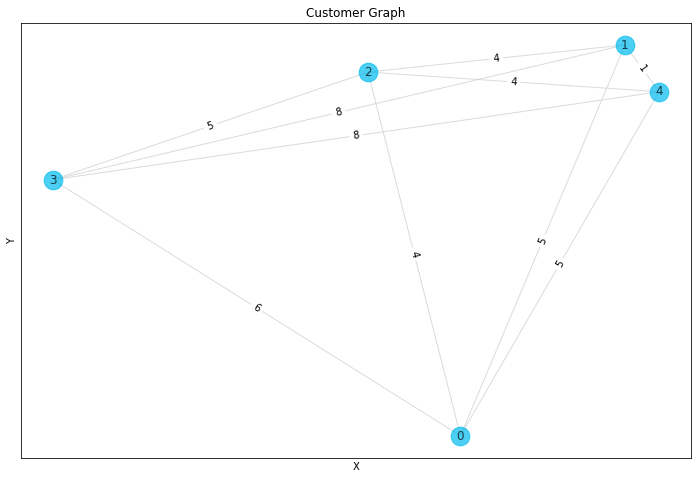

In [4]:
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
keys = range(len(xs))
pos = {}
for k in keys:
    pos[k] = (xs[k], ys[k])
print(pos)
#Plotting the customer location and route gra
plt.figure()
fig = plt.gcf()
ax=fig.gca()
fig.set_size_inches(12,8)
plt.title('Customer Graph')
plt.xlabel('X')
plt.ylabel('Y')

X = nx.Graph()
# Add Edges
for i in keys:
    for j in range(i+1, n):
        X.add_edge(i, j, length=int(instance[i][j]))

nx.draw_networkx(X, pos, node_size=350, edge_color='#cccccc',ax=ax,
                 nodelist=[0, 1, 2, 3, 4], node_color='#00bbee', alpha=0.7, with_labels=True)
labels = nx.get_edge_attributes(X, "length")
for k in labels.keys():
    labels[k] = int(labels[k])
print(labels)
nx.draw_networkx_edge_labels(X, pos, edge_labels=labels)
#plt.xticks((0, 0.5, 1), ("0", "0.5", "1"))
#plt.grid(True)
plt.show()

In [5]:
allpaths = nx.all_simple_paths(X, source=0, target=4)
#Print Hamiltonian Paths
selectedPaths = [path for path in list(allpaths) if len(path)==5]
print('All Hamiltonian Paths from 0-4 :\n', list(selectedPaths),'\n')
def cost_function(selectedPaths) :
    min_cost=1000
    min_cost_path = None
    for path in list(selectedPaths):
        total_length=5
        for k in range(len(path)-1):
            x,y = path[k], path[k+1]
            edge = X[x][y]
            length = edge['length']
            total_length += length
        print('{}: {}'.format(path, total_length))
        if min_cost>total_length:
            min_cost=total_length
            min_cost_path = path
    return min_cost, min_cost_path

min_cost, min_cost_path = cost_function(selectedPaths)
print('Minimum Cost : {} : {}'.format(min_cost_path, min_cost)  )   

# Print number of feasible solutions
f = math.factorial
no_feasible_solns = f(n) / f(K) / f(n-K)
print('Number of feasible solutions = ' + str(no_feasible_solns))

All Hamiltonian Paths from 0-4 :
 [[0, 1, 2, 3, 4], [0, 1, 3, 2, 4], [0, 2, 1, 3, 4], [0, 2, 3, 1, 4], [0, 3, 1, 2, 4], [0, 3, 2, 1, 4]] 

[0, 1, 2, 3, 4]: 27
[0, 1, 3, 2, 4]: 27
[0, 2, 1, 3, 4]: 29
[0, 2, 3, 1, 4]: 23
[0, 3, 1, 2, 4]: 27
[0, 3, 2, 1, 4]: 21
Minimum Cost : [0, 3, 2, 1, 4] : 21
Number of feasible solutions = 5.0


[0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0]


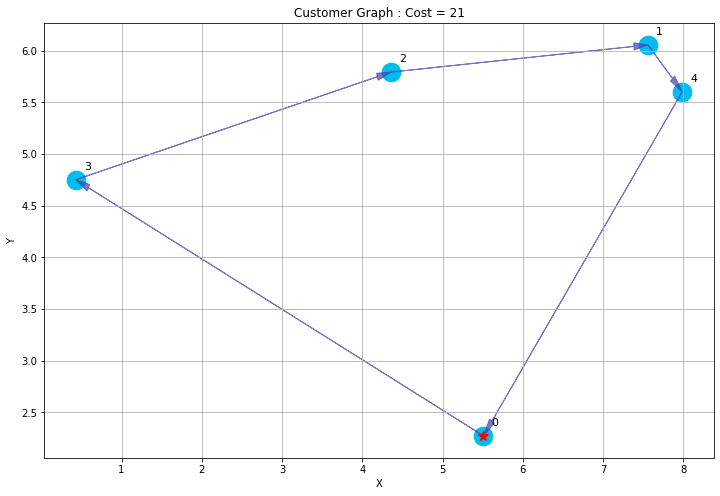

In [6]:
#Create the adjacency matrix
x=np.zeros((n,n), dtype=int)
for k in range(len(min_cost_path)-1):
    x[min_cost_path[k]][min_cost_path[k+1]]=1

x[min_cost_path[k+1]][0]=1
x=x.flatten()
print(x) 

# Visualize the solution
def visualize_solution(xc, yc, x, C, n):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(12,8)
    plt.title('Customer Graph : Cost = '+ str(classical_cost))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.scatter(xc, yc, s=350, color='#00bbee')
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.1, yc[i]+0.1), size=11, color='#000000')
    plt.plot(xc[0], yc[0], 'r*', ms=10)

    plt.grid()

    for k in range(0, n ** 2):

        if x[k] > 0:
            ix = k // n
            iy = k % n
            plt.arrow(xc[ix], yc[ix], 
                      xc[iy] - xc[ix], yc[iy] - yc[ix], 
                      length_includes_head=True, head_width=.07, head_length=2.5*0.07,
                     color='#4444aa', alpha=0.7)

    plt.show()    

classical_cost=min_cost
visualize_solution(xs, ys, x, classical_cost, n);

In [7]:
from qiskit.aqua.translators.ising.vehicle_routing import *
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log
# Loading your IBM Q account(s)
IBMQ.load_account()

#This gives the matrices. It is not required, as get_vehiclerouting_qubitops() anyway invokes this.
(Q, g, c) = get_vehiclerouting_matrices(instance, n, K)
# Q defines the interactions between variables
# g defines the contribution from the individual variables
# c is the constant offset
print (Q,'\n')
print(g,'\n')
print(c, '\n')

[[1600.  800.  800.  800.    0.    0.    0.    0.    0.  800.    0.    0.
     0.  800.    0.    0.    0.  800.    0.    0.]
 [ 800. 1600.  800.  800.    0.  800.    0.    0.    0.    0.    0.    0.
     0.    0.  800.    0.    0.    0.  800.    0.]
 [ 800.  800. 1600.  800.    0.    0.  800.    0.    0.    0.  800.    0.
     0.    0.    0.    0.    0.    0.    0.  800.]
 [ 800.  800.  800. 1600.    0.    0.    0.  800.    0.    0.    0.  800.
     0.    0.    0.  800.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1600.  800.  800.  800.  800.    0.    0.    0.
   800.    0.    0.    0.  800.    0.    0.    0.]
 [   0.  800.    0.    0.  800. 1600.  800.  800.    0.    0.    0.    0.
     0.    0.  800.    0.    0.    0.  800.    0.]
 [   0.    0.  800.    0.  800.  800. 1600.  800.    0.    0.  800.    0.
     0.    0.    0.    0.    0.    0.    0.  800.]
 [   0.    0.    0.  800.  800.  800.  800. 1600.    0.    0.    0.  800.
     0.    0.    0.  800.    0.    0.    0.    0.]


/opt/conda/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


In [8]:
#Create the operator for the Hamiltonian
qubitOp = get_vehiclerouting_qubitops(instance, n, K)
print(qubitOp.aer_paulis)
print(qubitOp.get_flat_pauli_list())
print('\nmatrix: ',qubitOp.matrix)
print('num qubits: ',qubitOp.num_qubits)

[[[-1602.5, 0.0], 'IIIIIIIIIIIIIIIIIIIZ'], [[-1602.0, 0.0], 'IIIIIIIIIIIIIIIIIIZI'], [[-1603.0, 0.0], 'IIIIIIIIIIIIIIIIIZII'], [[-1602.5, 0.0], 'IIIIIIIIIIIIIIIIZIII'], [[-1602.5, 0.0], 'IIIIIIIIIIIIIIIZIIII'], [[-1602.0, 0.0], 'IIIIIIIIIIIIIIZIIIII'], [[-1604.0, 0.0], 'IIIIIIIIIIIIIZIIIIII'], [[-1600.5, 0.0], 'IIIIIIIIIIIIZIIIIIII'], [[-1602.0, 0.0], 'IIIIIIIIIIIZIIIIIIII'], [[-1602.0, 0.0], 'IIIIIIIIIIZIIIIIIIII'], [[-1602.5, 0.0], 'IIIIIIIIIZIIIIIIIIII'], [[-1602.0, 0.0], 'IIIIIIIIZIIIIIIIIIII'], [[-1603.0, 0.0], 'IIIIIIIZIIIIIIIIIIII'], [[-1604.0, 0.0], 'IIIIIIZIIIIIIIIIIIII'], [[-1602.5, 0.0], 'IIIIIZIIIIIIIIIIIIII'], [[-1604.0, 0.0], 'IIIIZIIIIIIIIIIIIIII'], [[-1602.5, 0.0], 'IIIZIIIIIIIIIIIIIIII'], [[-1600.5, 0.0], 'IIZIIIIIIIIIIIIIIIII'], [[-1602.0, 0.0], 'IZIIIIIIIIIIIIIIIIII'], [[-1604.0, 0.0], 'ZIIIIIIIIIIIIIIIIIII'], [[400.0, 0.0], 'IIIIIIIIIIIIIIIIIIZZ'], [[400.0, 0.0], 'IIIIIIIIIIIIIIIIIZIZ'], [[400.0, 0.0], 'IIIIIIIIIIIIIIIIIZZI'], [[400.0, 0.0], 'IIIIIIIIIIIIIIIIZIIZ'],

/opt/conda/lib/python3.7/site-packages/qiskit/aqua/operators/weighted_pauli_operator.py:986: DeprecationWarning: get_flat_pauli_list() is deprecated and it will be removed after 0.6. Use `reorder_paulis()` instead
  DeprecationWarning)


AttributeError: 'WeightedPauliOperator' object has no attribute 'matrix'

In [9]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector

#We solve the problem classically...Purpose - to have a classical reference. 
#ExactEigensolver from qiskit is a classical algorithm
#it takes the operator of the Hamiltonian, 
ee = ExactEigensolver(qubitOp, k=1)
classical_result = ee.run()
import sys
np.set_printoptions(threshold=1000)
print(classical_result)
print('eigenvecs:',classical_result['eigvecs'])

2019-12-16 11:32:11,053:qiskit.aqua.parser.json_schema:DEBUG: Input: {
    "k": 1
}
2019-12-16 11:32:11,055:qiskit.aqua.parser.json_schema:DEBUG: Input Schema: {
    "$schema": "http://json-schema.org/schema#",
    "additionalProperties": false,
    "id": "ExactEigensolver_schema",
    "properties": {
        "k": {
            "default": 1,
            "minimum": 1,
            "type": "integer"
        }
    },
    "type": "object"
}


{'eigvals': array([17.+0.j]), 'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]), 'energy': 17.0, 'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]]), 'energies': array([17.])}
eigenvecs: [[0. 0. 0. ... 0. 0. 0.]]


In [10]:
offset = c
algo_input = EnergyInput(qubitOp)
print (algo_input)

algorithm_cfg = {
    'name': 'ExactEigensolver',
}

params = {
    'problem': {'name': 'ising'},
    'algorithm': algorithm_cfg
}
classical_result = run_algorithm(params, algo_input)

2019-12-16 11:32:18,622:qiskit.aqua.parser.json_schema:DEBUG: Input: {
    "aux_ops": null,
    "qubit_op": {
        "paulis": [
            {
                "coeff": {
                    "imag": 0.0,
                    "real": -1602.5
                },
                "label": "IIIIIIIIIIIIIIIIIIIZ"
            },
            {
                "coeff": {
                    "imag": 0.0,
                    "real": -1602.0
                },
                "label": "IIIIIIIIIIIIIIIIIIZI"
            },
            {
                "coeff": {
                    "imag": 0.0,
                    "real": -1603.0
                },
                "label": "IIIIIIIIIIIIIIIIIZII"
            },
            {
                "coeff": {
                    "imag": 0.0,
                    "real": -1602.5
                },
                "label": "IIIIIIIIIIIIIIIIZIII"
            },
            {
                "coeff": {
                    "imag": 0.0,
                    "real": 

2019-12-16 11:32:18,624:qiskit.aqua.parser.json_schema:DEBUG: Input Schema: {
    "$schema": "http://json-schema.org/schema#",
    "additionalProperties": false,
    "id": "energy_state_schema",
    "properties": {
        "aux_ops": {
            "default": null,
            "type": [
                "array",
                "null"
            ]
        },
        "qubit_op": {
            "default": {},
            "type": "object"
        }
    },
    "type": "object"
}
2019-12-16 11:32:18,652:qiskit.aqua.algorithms.classical.cplex.simple_cplex:INFO: CPLEX is not installed. See https://www.ibm.com/support/knowledgecenter/SSSA5P_12.8.0/ilog.odms.studio.help/Optimization_Studio/topics/COS_home.html
2019-12-16 11:32:18,655:qiskit.aqua.algorithms.classical.cplex.cplex_ising:DEBUG: CPLEX is not installed. See https://www.ibm.com/support/knowledgecenter/SSSA5P_12.8.0/ilog.odms.studio.help/Optimization_Studio/topics/COS_home.html No module named 'cplex'
2019-12-16 11:32:18,656:qiskit.aqua.

2019-12-16 11:32:19,027:qiskit.aqua._discover:DEBUG: Found: 'algorithm' has pluggables ['QAOA.Variational', 'QGAN', 'VQC', 'VQE', 'ExactEigensolver', 'ExactLSsolver', 'SVM', 'EOH', 'QSVM', 'AmplitudeEstimation', 'MaximumLikelihoodAmplitudeEstimation', 'BernsteinVazirani', 'DeutschJozsa', 'Grover', 'HHL', 'IQPE', 'QPE', 'Shor', 'Simon', 'QEomEE', 'QEomVQE'] 
2019-12-16 11:32:19,028:qiskit.aqua._discover:DEBUG: Found: 'eigs' has pluggables ['EigsQPE'] 
2019-12-16 11:32:19,028:qiskit.aqua._discover:DEBUG: Found: 'feature_map' has pluggables ['FirstOrderExpansion', 'PauliExpansion', 'PauliZExpansion', 'RawFeatureVector', 'SecondOrderExpansion'] 
2019-12-16 11:32:19,029:qiskit.aqua._discover:DEBUG: Found: 'initial_state' has pluggables ['CUSTOM', 'ZERO', 'HartreeFock'] 
2019-12-16 11:32:19,030:qiskit.aqua._discover:DEBUG: Found: 'iqft' has pluggables ['APPROXIMATE', 'STANDARD'] 
2019-12-16 11:32:19,031:qiskit.aqua._discover:DEBUG: Found: 'multiclass_extension' has pluggables ['AllPairs', 'E

2019-12-16 11:32:19,450:qiskit.aqua.qiskit_aqua:DEBUG: Algorithm Input: {
    "algorithm": {
        "k": 1,
        "name": "ExactEigensolver"
    },
    "input": {
        "aux_ops": null,
        "name": "EnergyInput",
        "qubit_op": {}
    },
    "problem": {
        "circuit_cache_file": null,
        "circuit_caching": false,
        "circuit_optimization_level": "default",
        "measurement_error_mitigation": false,
        "measurement_error_mitigation_refresh_period": 30,
        "measurement_error_mitigation_shots": null,
        "name": "ising",
        "num_processes": null,
        "random_seed": null,
        "skip_qobj_deepcopy": false,
        "skip_qobj_validation": true
    }
}
2019-12-16 11:32:19,451:qiskit.aqua.parser.json_schema:DEBUG: Input: {
    "k": 1
}
2019-12-16 11:32:19,452:qiskit.aqua.parser.json_schema:DEBUG: Input Schema: {
    "$schema": "http://json-schema.org/schema#",
    "additionalProperties": false,
    "id": "ExactEigensolver_schema",
    

In [ ]:
def q_solution(v, N):
    
    print(len(v))
    index_value = [x for x in range(len(v)) if v[x] == max(v)][0]
    string_value = "{0:b}".format(index_value)
    print(index_value, string_value)

    while len(string_value)<N:
        string_value = '0'+string_value

    sol = list()
    for elements in string_value:
        if elements == '0':
            sol.append(0)
        else:
            sol.append(1)

    sol = np.flip(sol, axis=0)

    return sol

print(classical_result)
quantum_solution = q_solution(classical_result['eigvecs'][0],n*(n+1))
ground_level = classical_result['energy'] + offset
print(quantum_solution)
print(ground_level)

{'eigvals': array([17.+0.j]), 'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]), 'energy': 17.0, 'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]]), 'energies': array([17.])}
1048576


In [ ]:
backend = BasicAer.get_backend('statevector_simulator')
seed = 50
#Now we use the VQE that needs two algorithms as sub-components
#Sub-Component 1 : a local optimizer, we use COBYLA(Constrained Optimization BY Linear Approximation) 
#from qiskit.aqua.components.optimizers

spsa = SPSA(max_trials=300)
cobyla = COBYLA()
cobyla.set_options(maxiter=100)
#Sub-Component 2 : a variational form, we use Ry from qiskit.aqua.components.variational_forms
#ry = RY(qubitOp.num_qubits, depth=2, entanglement='full')
ry = RY(qubitOp.num_qubits, depth=2, entanglement='linear')
vqe = VQE(qubitOp, ry, cobyla, 'matrix')
vqe.random_seed = seed
quantum_instance = QuantumInstance(backend=backend, seed=seed, seed_transpiler=seed)

In [ ]:
import time
start_time = time.time()
result = vqe.run(quantum_instance)
print("Ran For %s seconds" % (time.time() - start_time))

In [13]:
print('Full Result-Dict :',result)   
#quantum_solution = self._q_solution(result['eigvecs'][0], self.n * (self.n + 1))
quantum_solution_dict = result['eigvecs'][0]
print('0th EigenVector:', quantum_solution_dict)

Full Result-Dict : {'num_optimizer_evals': 100, 'min_val': 4338.0412621933565, 'opt_params': array([ 8.70447490e-01,  3.80203743e-01,  1.59144858e+00,  3.39884955e-01,
        2.80556392e+00,  3.57953947e+00, -2.01704129e+00,  3.21170573e+00,
       -2.40715635e-01,  2.75370385e+00,  2.76984584e+00,  2.51071393e-01,
        4.67543671e+00,  1.45525795e+00,  2.51348970e+00, -7.32933741e-02,
        1.17028259e+00,  3.83987758e+00, -3.35971446e+00,  2.51877306e+00,
        5.68239313e-01,  2.10218503e+00,  1.39346754e+00, -1.46891561e+00,
        3.11787070e+00, -1.42682879e+00, -1.19069309e+00,  3.39310924e+00,
        2.39021626e+00,  3.28722137e+00, -2.54009132e+00,  4.30268361e-01,
       -1.92027017e-02, -3.32295859e+00,  3.02639699e+00,  5.03711190e-03,
       -1.57273857e+00,  1.91270530e+00, -3.09845890e+00,  1.69412632e+00,
        1.52851032e+00, -4.90451771e-01,  2.40438467e+00, -1.74863127e+00,
       -1.64991876e+00,  1.56283967e+00, -1.70576738e+00, -3.39276898e-02,
       

In [63]:
#get_vehiclerouting_solution(instance, n, K, result)
v = result['eigvecs'][0]
N = (n - 1) * n
#N = n**2
print('No of eigenvecs: ',len(v))
v_sorted=np.sort(v)
print(v_sorted[0],v_sorted[1],v_sorted[2],v_sorted[3],v_sorted[4])
#maxval=max(v)
maxval=v_sorted[8]
#maxval=min(v)
#index_value = [x for x in range(len(v)) if v[x] == max(v)][0]
index_value = (np.where(v==maxval))[0]
string_value = "{0:b}".format(index_value[0])
#make string_value of N digits - 0 fill
string_value = string_value.rjust(N,'0')
print(index_value[0], maxval, string_value)

No of eigenvecs:  1048576
(-0.1806490410190131+0j) (-0.1757996533031375+0j) (-0.1370729913603559+0j) (-0.1333928108014049+0j) (-0.1076850664326725+0j)
136258 (-0.0893700878895119+0j) 00100001010001000010


N: 20 00100001010001000010  :  [0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0]
Solution:  [0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0]
[[0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]]
[0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0]
[[0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]]


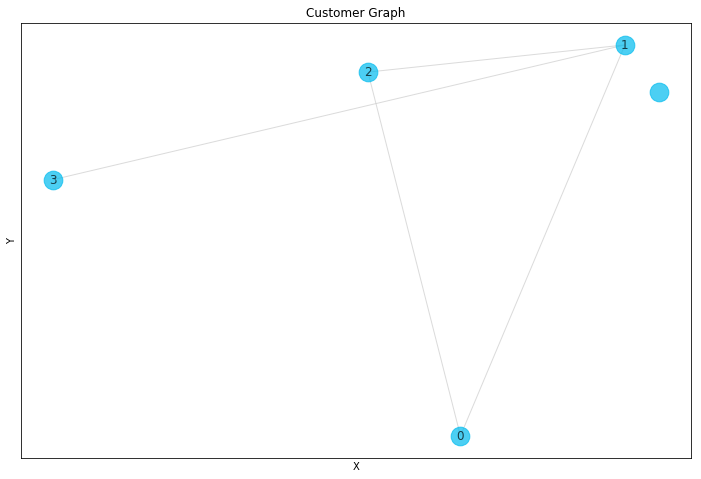

'\n0 0 0 1 0\n0 0 0 0 1\n0 1 0 0 0\n0 0 1 0 0\n1 0 0 0 0 \n[0, 3, 2, 1, 4] : 29\n[[0 1 0 0 0]\n [1 0 0 0 0]\n [0 0 1 0 0]\n [0 0 0 0]\n [0 1 0 0]]\n \n'

In [64]:
x_sol = list()
for elements in string_value:
    if elements == '0':
        x_sol.append(0)
    else:
       x_sol.append(1)
x_sol = np.flip(x_sol, axis=0)
print('N:',N,string_value,' : ',x_sol)
print('Solution: ', x_sol)

x_mat1 = x_sol.reshape(5,4)
X0 = np.zeros((5,1))
#x_mat = np.hstack((x_mat1,X0))
print (x_mat1)
print(x)

#x_quantum2 = get_vehiclerouting_solution(instance, n, K, result)
#print(x_quantum2)

#adj_mat=[[0,1],[1,2],[3,0],[4,1]]
adj_mat = np.delete(x_mat1,(2), axis=0)
print(adj_mat)
A=np.matrix(adj_mat)
G_Q=nx.from_numpy_matrix(A)
plt.figure()
fig = plt.gcf()
ax=fig.gca()
fig.set_size_inches(12,8)
plt.title('Customer Graph')
plt.xlabel('X')
plt.ylabel('Y')

nx.draw_networkx(G_Q, pos, node_size=350, edge_color='#cccccc',ax=ax,
                 nodelist=[0, 1, 2, 3, 4], node_color='#00bbee', alpha=0.7, with_labels=True)
#labels = nx.get_edge_attributes(X, "length")
#for k in labels.keys():
#    labels[k] = int(labels[k])
#print(labels)
#nx.draw_networkx_edge_labels(G_Q, pos, edge_labels=labels)
#plt.xticks((0, 0.5, 1), ("0", "0.5", "1"))
#plt.grid(True)
plt.show()
"""
0 0 0 1 0
0 0 0 0 1
0 1 0 0 0
0 0 1 0 0
1 0 0 0 0 
[0, 3, 2, 1, 4] : 29
[[0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0]
 [0 1 0 0]]
 
"""

In [62]:
#quantum_cost2 = get_vehiclerouting_cost(instance, n, K, x_quantum2)
#(Q, g, c) = get_vehiclerouting_matrices(instance, n, K)
fun = lambda x: np.dot(np.around(x), np.dot(Q, np.around(x))) + np.dot(g, np.around(x)) + c
cost = fun(x_sol)
print (x_sol, type(x_sol), x_sol.shape, cost)

#Compare with [0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0]
#x=np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])
y=x[2:22]
print(y, type(y), y.shape, fun(y))

[0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0] <class 'numpy.ndarray'> (20,) 4819.0
[0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0] <class 'numpy.ndarray'> (20,) 3221.0


In [ ]:
#Solution using Quantum Approximate Optimization Algorithm (QAOA)start_time = time.time()
#Another variational algorithm that uses an internal variational form, created based on the problem.
backend = BasicAer.get_backend('statevector_simulator')
seed = 50

#Specify the optimizer - Constrained Optimization BY Linear Approximation algorithm.
#It Uses scipy.optimize.minimize COBYLA  
cobyla = COBYLA()
cobyla.set_options(maxiter=250)

qaoa = QAOA(qubitOp, cobyla, 3)
qaoa.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed=seed, seed_transpiler=seed)

result = qaoa.run(quantum_instance)

"""declarative approach
algorithm_cfg = {
    'name': 'QAOA.Variational',
    'p': 3,
    'operator_mode': 'matrix'
}

optimizer_cfg = {
    'name': 'COBYLA',
    'maxiter': 250
}

params = {
    'problem': {'name': 'ising', 'random_seed': seed},
    'algorithm': algorithm_cfg,
    'optimizer': optimizer_cfg
}
result = run_algorithm(params, algo_input, backend=backend)
"""
print_result(result)

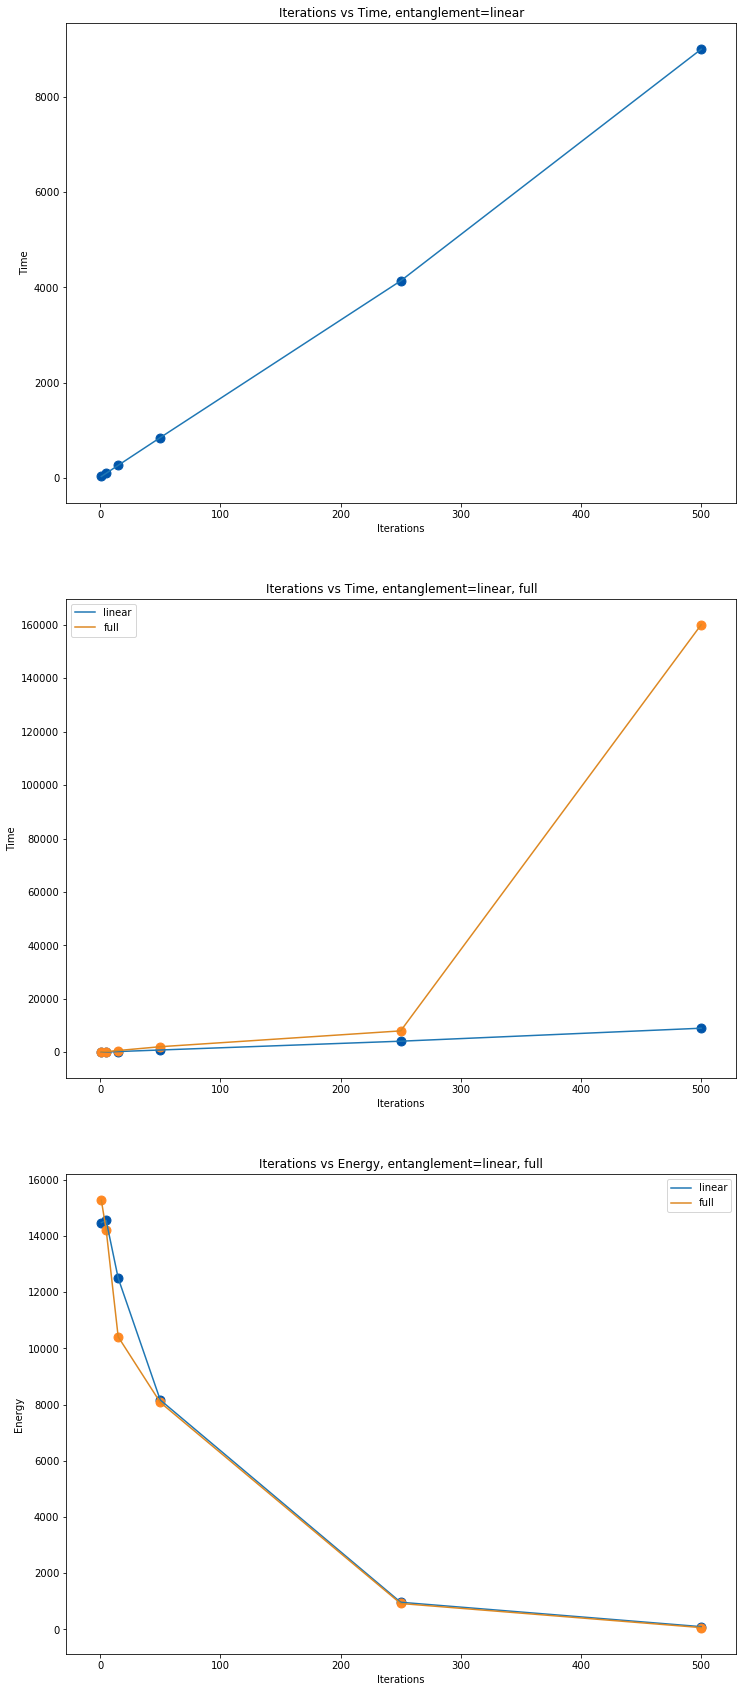

In [21]:
import matplotlib.pyplot as plt
x= [1,5,15,50,250,500]
time_linear = [34,100,267,849,4138,9000]
energy_linear = [14474,14551,12499,8164,968,100]

time_full=[84,249,649,2076,8000,160000]
energy_full=[15266,14219,10411,8078,924,67]

f, axarr = plt.subplots(3,1)
f.set_size_inches(12,30)
plt.title('Metrics')

axarr[0].plot(x, time_linear, label='linear')
axarr[0].scatter(x, time_linear, s=80, color='#0055aa')
axarr[0].set_title('Iterations vs Time, entanglement=linear')
axarr[0].set_xlabel('Iterations')
axarr[0].set_ylabel('Time')

axarr[1].plot(x, time_linear, label='linear')
axarr[1].scatter(x, time_linear, s=80, color='#0055aa')
axarr[1].set_title('Iterations vs Time, entanglement=linear, full')

axarr[1].plot(x, time_full, color='#dd8822',label='full')
axarr[1].scatter(x, time_full,s=80, color='#ff8822')
axarr[1].set_xlabel('Iterations')
axarr[1].set_ylabel('Time')
axarr[1].legend()

axarr[2].plot(x, energy_linear,label='linear')
axarr[2].scatter(x, energy_linear, s=80, color='#0055aa')
axarr[2].set_title('Iterations vs Energy, entanglement=linear, full')


axarr[2].plot(x, energy_full,color='#dd8822', label='full')
axarr[2].scatter(x, energy_full,s=80, color='#ff8822')
axarr[2].set_xlabel('Iterations')
axarr[2].set_ylabel('Energy')
axarr[2].legend()

# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
#plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
#plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

plt.show()

In [22]:
max_trials=1000
#binary_representation
#A parameter of cost function - very large
A = np.max(instance) * 100  

# Determine the weights w
#Flatten instance
instance_vec = instance.reshape(n ** 2)
#only non-zero weights(=distance) - discarding the diagonal essentially
w_list = [instance_vec[x] for x in range(n ** 2) if instance_vec[x] > 0]
w = np.zeros(n * (n - 1))
for ii in range(len(w_list)):
    w[ii] = w_list[ii]

print('weights: ',w)    
    
#Internal variables
#nxn Identity Matrix 
Id_n = np.eye(n)
#n-1xn-1 One's Matrix 
Im_n_1 = np.ones([n - 1, n - 1])
Iv_n_1 = np.ones(n)
Iv_n_1[0] = 0
Iv_n = np.ones(n-1)
neg_Iv_n_1 = np.ones(n) - Iv_n_1
print('Iv_n_1: ',Iv_n_1)
print('Iv_n:',Iv_n)
print('neg_Iv_n_1: ',neg_Iv_n_1)

v = np.zeros([n, n*(n-1)])
for ii in range(n):
    count = ii-1
    print(count)
    for jj in range(n*(n-1)):
        print(ii,jj,jj//(n-1),jj%(n-1))
        if jj//(n-1) == ii:
            count = ii

        if jj//(n-1) != ii and jj%(n-1) == count:
            v[ii][jj] = 1.
            print('---------------- 1')

vn = np.sum(v[1:], axis=0)
print('v: ',v)
print(vn)

weights:  [5. 4. 6. 5. 5. 4. 8. 1. 4. 4. 5. 4. 6. 8. 5. 8. 5. 1. 4. 8.]
Iv_n_1:  [0. 1. 1. 1. 1.]
Iv_n: [1. 1. 1. 1.]
neg_Iv_n_1:  [1. 0. 0. 0. 0.]
-1
0 0 0 0
0 1 0 1
0 2 0 2
0 3 0 3
0 4 1 0
---------------- 1
0 5 1 1
0 6 1 2
0 7 1 3
0 8 2 0
---------------- 1
0 9 2 1
0 10 2 2
0 11 2 3
0 12 3 0
---------------- 1
0 13 3 1
0 14 3 2
0 15 3 3
0 16 4 0
---------------- 1
0 17 4 1
0 18 4 2
0 19 4 3
0
1 0 0 0
---------------- 1
1 1 0 1
1 2 0 2
1 3 0 3
1 4 1 0
1 5 1 1
1 6 1 2
1 7 1 3
1 8 2 0
1 9 2 1
---------------- 1
1 10 2 2
1 11 2 3
1 12 3 0
1 13 3 1
---------------- 1
1 14 3 2
1 15 3 3
1 16 4 0
1 17 4 1
---------------- 1
1 18 4 2
1 19 4 3
1
2 0 0 0
2 1 0 1
---------------- 1
2 2 0 2
2 3 0 3
2 4 1 0
2 5 1 1
---------------- 1
2 6 1 2
2 7 1 3
2 8 2 0
2 9 2 1
2 10 2 2
2 11 2 3
2 12 3 0
2 13 3 1
2 14 3 2
---------------- 1
2 15 3 3
2 16 4 0
2 17 4 1
2 18 4 2
---------------- 1
2 19 4 3
2
3 0 0 0
3 1 0 1
3 2 0 2
---------------- 1
3 3 0 3
3 4 1 0
3 5 1 1
3 6 1 2
---------------- 1
3 7 1 3
3 8

In [12]:
# Q defines the interactions between variables
print(np.kron([[1,0],[0,1]],[[2,3],[1,2]]))
print(np.kron(Id_n, Im_n_1))
print(np.dot(v.T,v))

Q = A*(np.kron(Id_n, Im_n_1) + np.dot(v.T, v))
print (Q)
# g defines the contribution from the individual variables
g = w - 2 * A * (np.kron(Iv_n_1,Iv_n) + vn.T) - \
        2 * A * K * (np.kron(neg_Iv_n_1, Iv_n) + v[0].T)

# c is the constant offset
c = 2 * A * (n-1) + 2 * A * (K ** 2)
print(g)
print(c)
x_sol=np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0])

max(x_sol)
# Evaluates the cost distance from a binary representation of a path
fun = lambda x: np.dot(np.around(x), np.dot(Q, np.around(x))) + np.dot(g, np.around(x)) + c
cost = fun(x_sol)

print(cost)

[[2 3 0 0]
 [1 2 0 0]
 [0 0 2 3]
 [0 0 1 2]]


NameError: name 'Id_n' is not defined

In [ ]:


"""



    def construct_hamiltonian(self):

        instance = self.instance
        n = self.n
        K = self.K

        N = (n - 1) * n  # number of qubits
        Q,g,c,_ = self.binary_representation()

        # Defining the new matrices in the Z-basis

        Iv = np.ones(N)
        Qz = (Q / 4)
        gz = (-g / 2 - np.dot(Iv, Q / 4) - np.dot(Q / 4, Iv))
        cz = (c + np.dot(g / 2, Iv) + np.dot(Iv, np.dot(Q / 4, Iv)))

        cz = cz + np.trace(Qz)
        Qz = Qz - np.diag(np.diag(Qz))

        # Getting the Hamiltonian in the form of a list of Pauli terms

        pauli_list = []
        for i in range(N):
            if gz[i] != 0:
                wp = np.zeros(N)
                vp = np.zeros(N)
                vp[i] = 1
                pauli_list.append((gz[i], Pauli(vp, wp)))
        for i in range(N):
            for j in range(i):
                if Qz[i, j] != 0:
                    wp = np.zeros(N)
                    vp = np.zeros(N)
                    vp[i] = 1
                    vp[j] = 1
                    pauli_list.append((2 * Qz[i, j], Pauli(vp, wp)))

        pauli_list.append((cz, Pauli(np.zeros(N), np.zeros(N))))

        return cz, pauli_list

    def check_hamiltonian(self):

        cz, op = self.construct_hamiltonian()
        Op = Operator(paulis=op)

        qubitOp, offset = Op, 0
        algo_input = EnergyInput(qubitOp)

        # Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector

        algorithm_cfg = {
            'name': 'ExactEigensolver',
        }

        params = {
            'problem': {'name': 'ising'},
            'algorithm': algorithm_cfg
        }
        result = run_algorithm(params, algo_input)

        quantum_solution = self._q_solution(result['eigvecs'][0],self.n*(self.n+1))
        ground_level = result['energy'] + offset

        return quantum_solution, ground_level

    def vqe_solution(self):

        cz, op = self.construct_hamiltonian()
        Op = Operator(paulis=op)

        qubitOp, offset = Op, cz
        algo_input = EnergyInput(qubitOp)


        algorithm_cfg = {
            'name': 'VQE',
            'operator_mode': 'paulis'
        }

        optimizer_cfg = {
            'name': 'SPSA',
            'max_trials': self.max_trials
        }

        var_form_cfg = {
            'name': 'RY',
            'depth': 5,
            'entanglement': 'linear'
        }

        params = {
            'problem': {'name': 'ising', 'random_seed': 10598},
            'algorithm': algorithm_cfg,
            'optimizer': optimizer_cfg,
            'variational_form': var_form_cfg,
            'backend': {'name': 'qasm_simulator'
                        }
        }

        result = run_algorithm(params, algo_input)

        #quantum_solution = self._q_solution(result['eigvecs'][0], self.n * (self.n + 1))
        quantum_solution_dict = result['eigvecs'][0]

        q_s = max(quantum_solution_dict.items(), key=operator.itemgetter(1))[0]
        quantum_solution= [int(chars) for chars in q_s]
        quantum_solution = np.flip(quantum_solution, axis=0)

        _,_,_,level = self.binary_representation(x_sol=quantum_solution)
        return quantum_solution_dict, quantum_solution, level

    def _q_solution(self, v, N):

        index_value = [x for x in range(len(v)) if v[x] == max(v)][0]
        string_value = "{0:b}".format(index_value)

        while len(string_value)<N:
            string_value = '0'+string_value

        sol = list()
        for elements in string_value:
            if elements == '0':
                sol.append(0)
            else:
                sol.append(1)

        sol = np.flip(sol, axis=0)

        return sol
"""        